# San Francisco Airbnb Exploratory Data Analysis
A Proposed Capstone Project for TDI
Haoming Jin

In [24]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_original = pd.read_pickle('airbnb_SF_2019_04_to_2020_04.pkl')

The Data is downloaded and cleaned in the previous notebook:San_Francisco_Airbnb_Data_Cleaning.ipynb and saved as a pickle file.

In this notebook we do some exploratory data analysis.
for reference the data contains the following information:

In [7]:
df_original.info(verbose = True, null_counts= True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12074 entries, 0 to 7275
Data columns (total 83 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            12074 non-null  object        
 1   last_scraped                                  12074 non-null  datetime64[ns]
 2   name                                          12074 non-null  object        
 3   summary                                       11730 non-null  object        
 4   space                                         10064 non-null  object        
 5   description                                   11947 non-null  object        
 6   neighborhood_overview                         8759 non-null   object        
 7   notes                                         6860 non-null   object        
 8   transit                                       8106 non-null   objec

In [8]:
col_lists = ['id','host_name','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost',
            'host_total_listings_count','neighbourhood_cleansed','latitude','longitude','is_location_exact','property_type',
            'room_type', 'accommodates','bathrooms','bedrooms','beds','bed_type','price','weekly_price','monthly_price',
            'security_deposit','cleaning_fee','guests_included']
df = df_original[col_lists]

First I would like to have a visual inspection of how the data looks on the map

### Some map visualizations

The density of all locations is plotted as a heatmap.

In [169]:
import folium
from folium.plugins import HeatMap
m=folium.Map([37.76,-122.44,],zoom_start=13)
HeatMap(df[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
display(m)

The prices are plotted on the map as colored dots.

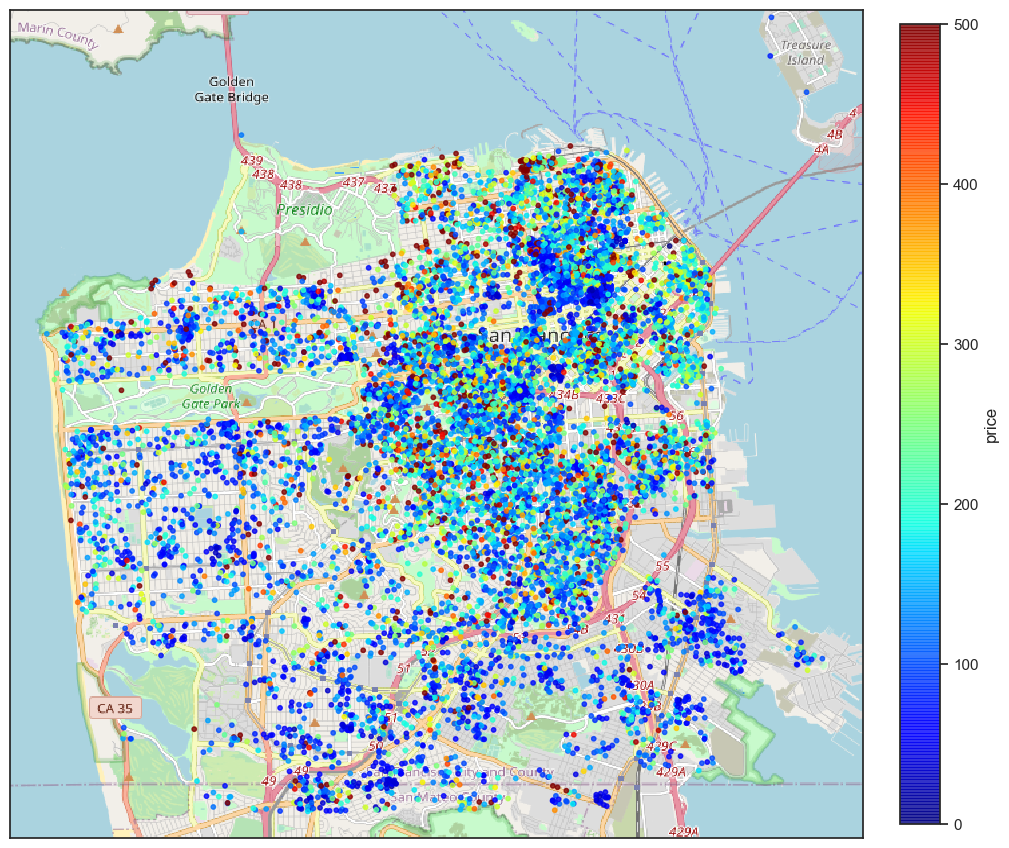

In [558]:
BBox = [-122.52,-122.3594,37.7,37.83]
north_CA_map = plt.imread('SF_map.png')
fig, ax = plt.subplots(figsize = (12,12))
xbins = np.arange(BBox[0],BBox[1]+0.001, 0.001)
ybins = np.arange(BBox[2],BBox[3]+0.001, 0.001)

#ax.hist2d('longitude', 'latitude', bins = [xbins,ybins], data = df, cmap = 'winter', cmin = 2)
im = ax.scatter(df.longitude, df.latitude, zorder=1, alpha= 0.8, c = df.price, cmap = plt.get_cmap('jet'), 
                s=10 ,vmax = 500)
fig.colorbar(im, ax = ax, fraction = 0.043, pad = 0.04, label = 'price')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.imshow(north_CA_map, zorder=0, extent = BBox, aspect= 1.2)
plt.xticks([])
plt.yticks([]);

## Some questions that can be answered by data

Which neighbourhoods have the highest number of hosts and what is the price distribution of each neighborhood?

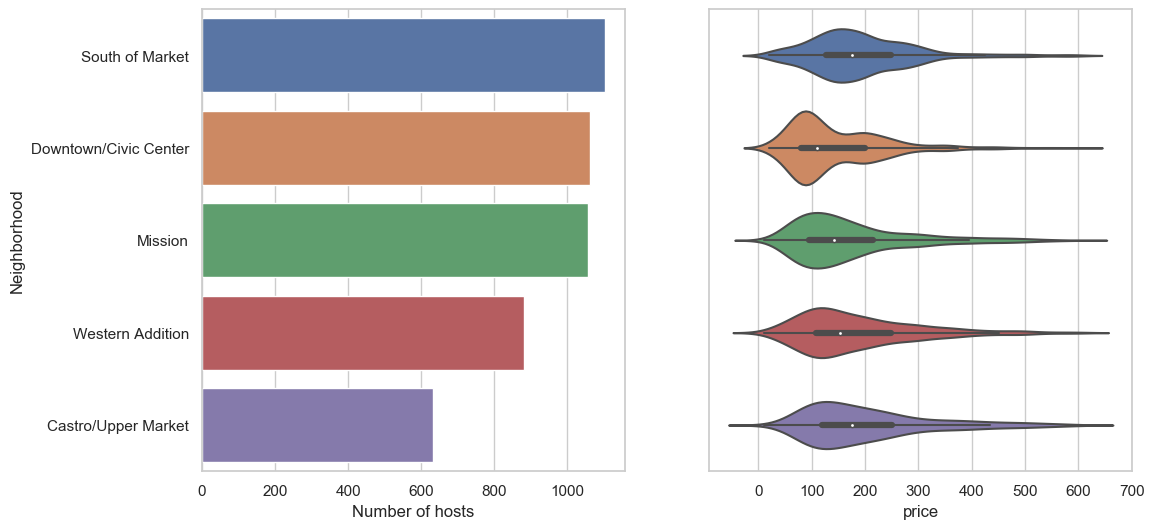

In [571]:
sns.set(style = 'whitegrid')
neighbour_list = df.neighbourhood_cleansed.value_counts()[0:5]
neighbour_count = np.array(neighbour_list)
neighbour_list = np.array(neighbour_list.index)
fig, ax = plt.subplots(1,2,figsize = (12,6))

sns.barplot(x = neighbour_count, y = neighbour_list, ax = ax[0])
df_sub = df.query('neighbourhood_cleansed in @neighbour_list and price < 600')

sns.violinplot(data = df_sub, y='neighbourhood_cleansed', x ='price',order = neighbour_list, ax = ax[1]);
#plt.xticks(rotation = 20)
ax[0].set_ylabel('Neighborhood')
ax[0].set_xlabel('Number of hosts')
ax[1].set_ylabel('')
ax[1].set_yticks([]);

The following plot shows the locations in these neighbourhoods on the map.

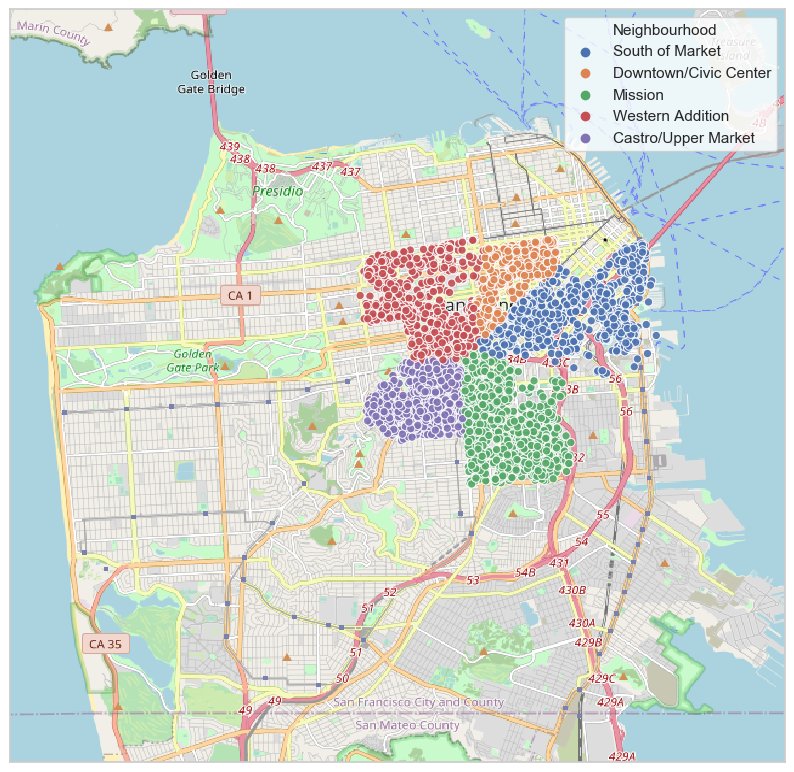

In [589]:
BBox = [-122.52,-122.3594,37.7,37.83]
north_CA_map = plt.imread('SF_map.png')
fig, ax = plt.subplots(figsize = (10,10))
sns.scatterplot(data = df_sub, x = 'longitude', y = 'latitude', hue = 'neighbourhood_cleansed',
                hue_order = neighbour_list,alpha = 0.9,ax = ax)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.imshow(north_CA_map, zorder=0, extent = BBox, aspect= 1.2)
(ax.legend()).texts[0].set_text('Neighbourhood')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

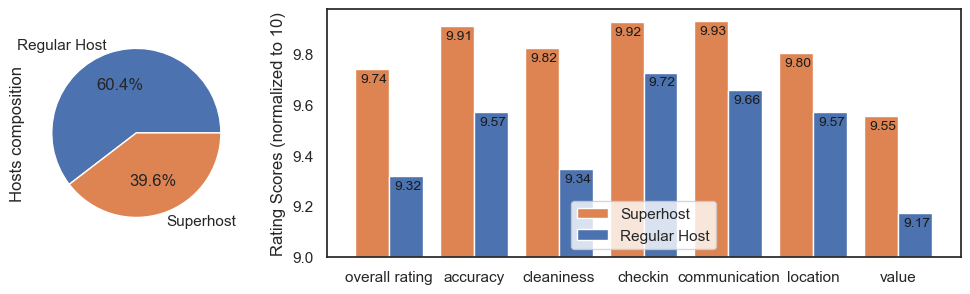

In [640]:
ratings = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
           'review_scores_communication','review_scores_location','review_scores_value']
super_ratings = df_original[['host_is_superhost']+ratings].dropna().query('host_is_superhost == True').mean()[1:]
super_ratings[0] /= 10
reg_ratings = df_original[['host_is_superhost']+ratings].dropna().query('host_is_superhost != True').mean()[1:]
reg_ratings[0] /= 10

sns.set(style = 'white')
fig, ax = plt.subplots(1,2, figsize = (12,6),gridspec_kw={'width_ratios': [1,3]})
df.host_is_superhost.value_counts().plot.pie(autopct = '%1.1f%%', ax = ax[0], labels = ['Regular Host','Superhost']);
ax[0].set_ylabel('Hosts composition');
ax[1].set_aspect(3)
plt.bar(x = np.arange(len(ratings)) - 0.2, height = super_ratings - 9,
        width = 0.4, bottom = 9, color = sns.color_palette()[1])
plt.bar(x = np.arange(len(ratings)) + 0.2, height = reg_ratings - 9,
        width = 0.4, bottom = 9, color = sns.color_palette()[0])
plt.xticks(range(len(ratings)),['overall rating','accuracy','cleaniness','checkin','communication','location','value'],
           rotation = 0)
for p in ax[1].patches:
        percentage = '{:.2f}'.format(p.get_height() + 9)
        x = p.get_x()+0.06
        y = p.get_height() + 8.95
        ax[1].annotate(percentage, (x, y),color = 'k', size = 10)
ax[1].legend(['Superhost','Regular Host'],loc = 'lower center')
ax[1].set_ylabel('Rating Scores (normalized to 10)');

# A Machine Learning Price Prediction
Let's use Machine Learning to build a model to predict the prices.

In [491]:
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [474]:
ml_col_lists = ['neighbourhood_cleansed','property_type',
            'room_type', 'accommodates','bathrooms','bedrooms','beds','bed_type','price']

In [483]:
df_lr = df_original[ml_col_lists].copy()
df_lr.rename({'neighbourhood_cleansed':'neighbourhood'},axis = 1,inplace = True)

In [548]:
# Some of the prices over 500 are extremely high, and may intercept with fitting
# dropping these data gets rids of 5% of the total data
# Encode the categorical data as one hot
df_lr_oh_all = pd.get_dummies(df_lr, columns = ['neighbourhood','property_type','room_type','bed_type'],drop_first = True)
df_lr_oh = df_lr_oh_all.query('price <= 500')

In [549]:
# drop total 83 rows that contains null values
df_lr_oh = df_lr_oh[~df_lr_oh.isnull().any(axis = 1)]

In [550]:
X = df_lr_oh.drop('price', axis = 1)
y = df_lr_oh.price

In [551]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In totoal 8451 training data, 3623 test data.

In [644]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict result using test data
y_pred = lr.predict(X_test)

In [645]:
pd.DataFrame({'price':y_test, 'predicted price': y_pred}).sample(10)

,price,predicted price
4123,300.0,201.593739
5904,139.0,160.519557
4107,200.0,127.766536
532,175.0,190.977705
2085,50.0,89.598370
8139,107.0,143.072506
1000,94.0,87.223946
1502,265.0,109.854235
6753,199.0,192.005130
2831,349.0,222.840684


## Model Evaluation

In this part, we will use 3 metric to evaluate the predictions:
1. Mean absolute error (MAE)
2. Root Mean Square Error (RMSE)
3. R2

In [646]:
print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test, y_pred)))

MAE =  51.773
RMSE =  71.587
R2 score =  0.513


## Ridge and Lasso Regression
We have many parameters and are very probable to get overfitting, Let's try adding some regulations:

In [648]:
lr = Ridge(alpha = 0.1)
lr.fit(X_train, y_train)

# predict result using test data
y_pred = lr.predict(X_test)
print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test, y_pred)))

MAE =  51.766
RMSE =  71.585
R2 score =  0.513


In [649]:
lr = Lasso(alpha = 0.1)
lr.fit(X_train, y_train)

# predict result using test data
y_pred = lr.predict(X_test)

print('MAE = ', '{:.3f}'.format(metrics.mean_absolute_error(y_test, y_pred)))
print('RMSE = ','{:.3f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
print('R2 score = ', '{:.3f}'.format(metrics.r2_score(y_test, y_pred)))

MAE =  51.999
RMSE =  72.110
R2 score =  0.506
